In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
base = automap_base()
# reflect the tables
base.prepare(engine, reflect=True)

In [6]:
# View all of the classes that automap found
base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = base.classes.measurement
Station = base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session=Session(engine)

# Exploratory Precipitation Analysis

In [19]:
# Find the most recent date in the data set.
most_recent_date = session.query(func.max(Measurement.date)).scalar()

most_recent_date

'2017-08-23'

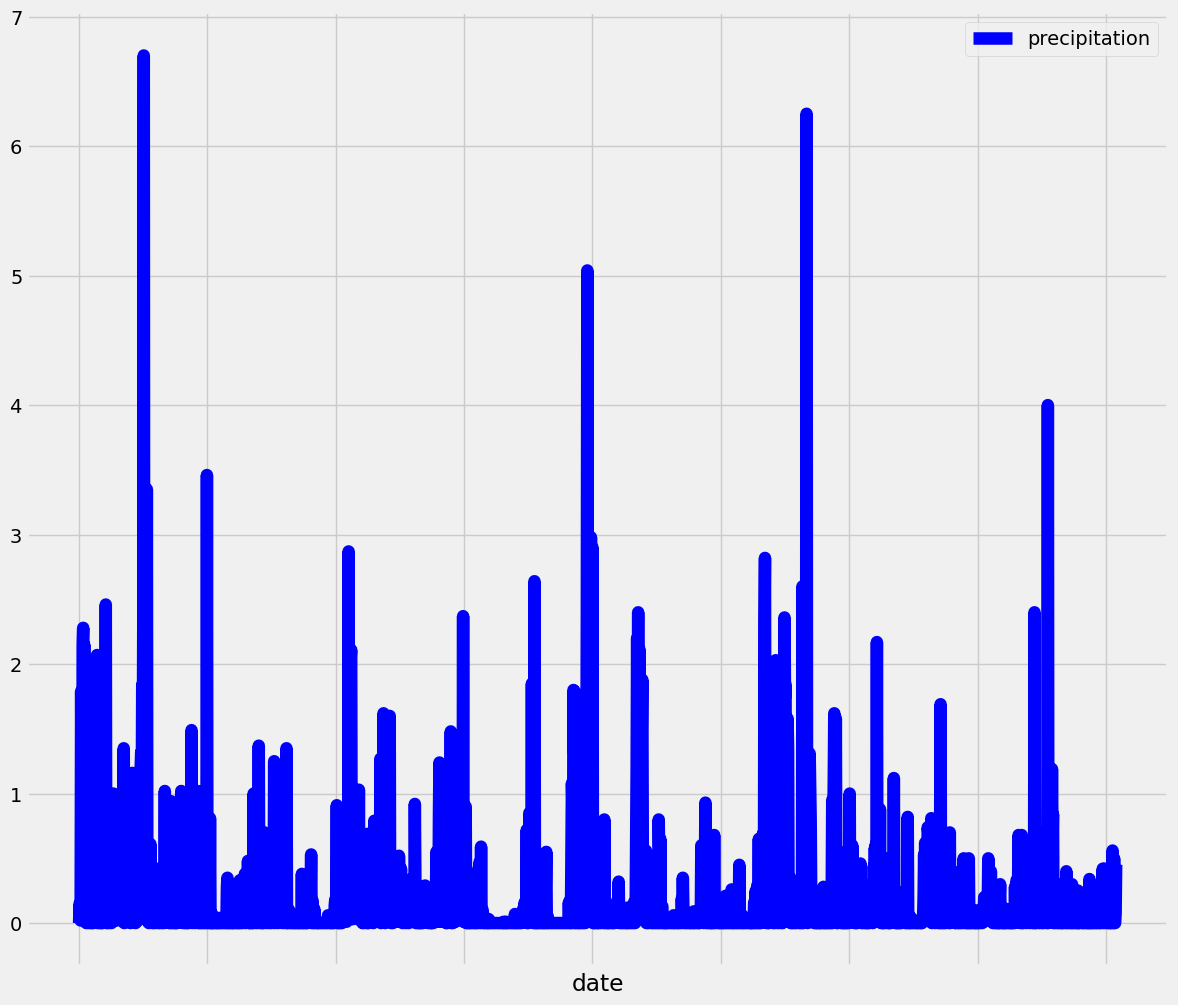

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
results=session.query(Measurement.date).order_by(Measurement.date.desc()).first()

start_date=list(np.ravel(results))[0]

late_date=dt.datetime.strptime(start_date,"%Y-%m-%d")

year_back=late_date-dt.timedelta(days=366)
# Perform a query to retrieve the data and precipitation scores
results=session.query(Measurement.date, Measurement.prcp).order_by(Measurement.date.asc()).\
        filter(Measurement.date>=year_back).all()


# Save the query results as a Pandas DataFrame. Explicitly set the column names
df_results=pd.DataFrame(results)
df_results=df_results.rename(columns={"prcp":"precipitation"})

# Sort the dataframe by date
df_results.sort_values(by=['date'], ascending=True)
df_results=df_results.dropna()
df_results=df_results.reset_index(drop=True)


# Use Pandas Plotting with Matplotlib to plot the data
ax = df_results.plot(color='b', figsize=(12, 10), legend=True, linewidth=9.0, grid=True)
# Removing xticks
plt.setp(ax.get_xticklabels(), visible=False)
# Adjust layout and labels
plt.tight_layout()
plt.xlabel("date")
plt.show()

In [11]:
# Use Pandas to calculate the summary statistics for the precipitation data
df_results.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [12]:
# Design a query to calculate the total number of stations in the dataset
total_stations=session.query(func.count(Station.id)).all()
total_stations

[(9,)]

In [13]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.

active_stations = session.query(
    Measurement.station,
    func.count(Measurement.station)
).group_by(
    Measurement.station
).order_by(
    func.count(Measurement.station).desc()
).all()

# Output the list of stations and their counts
active_stations



[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [14]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.


most_active_station = active_stations[0][0]

# Query to calculate the lowest, highest, and average temperature for the most active station
temperature_stats = session.query(
    func.min(Measurement.tobs),
    func.max(Measurement.tobs),
    func.avg(Measurement.tobs)
).filter(
    Measurement.station == most_active_station
).all()

# Extract the results
lowest_temp, highest_temp, avg_temp = temperature_stats[0]

# Print the results
print(f"Station: {most_active_station}")
print(f"Lowest Temperature: {lowest_temp}")
print(f"Highest Temperature: {highest_temp}")
print(f"Average Temperature: {avg_temp}")



Station: USC00519281
Lowest Temperature: 54.0
Highest Temperature: 85.0
Average Temperature: 71.66378066378067


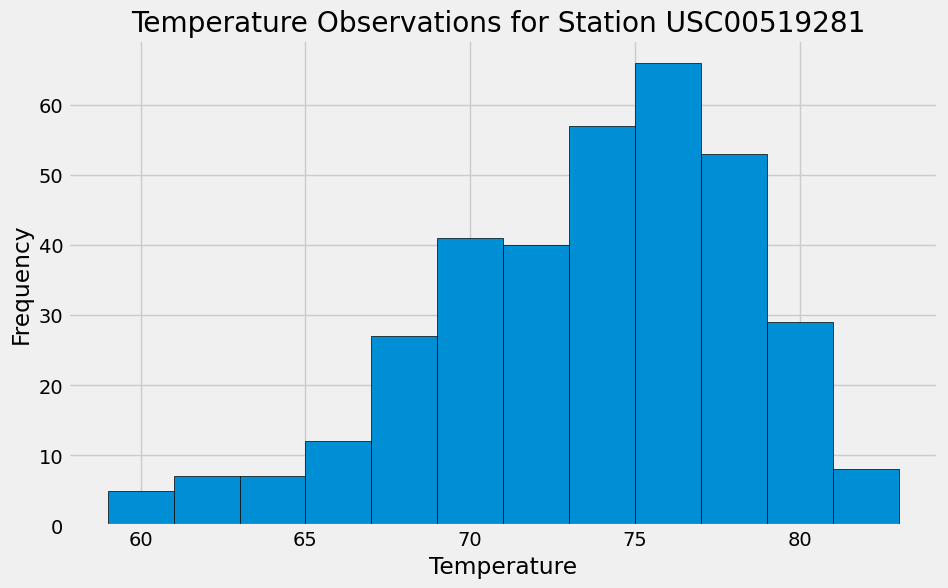

In [17]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

most_active_station = active_stations[0][0]

# Calculate the date 12 months ago from the last date in the dataset
last_date = session.query(func.max(Measurement.date)).scalar()
one_year_ago = (pd.to_datetime(last_date) - pd.DateOffset(years=1)).strftime('%Y-%m-%d')

# Query the last 12 months of temperature observation data for the most active station
temperature_data = session.query(Measurement.tobs).filter(
    Measurement.station == most_active_station,
    Measurement.date >= one_year_ago
).all()

# Convert the query results to a list
temperature_list = [temp[0] for temp in temperature_data]

# Create a histogram of the temperature observations
plt.figure(figsize=(10, 6))
plt.hist(temperature_list, bins=12, edgecolor='black')
plt.title(f'Temperature Observations for Station {most_active_station} ')
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Close Session

In [18]:
# Close Session
session.close()